In [20]:
import pymongo
import pandas
import datetime

client = pymongo.MongoClient("mongodb://localhost:27017/newsSearch")
db = client["newsSearch"]
newspaperCollection = "newspaper"
redditCollection = "reddit"

# all newsItems
all_newsDataset = db[newspaperCollection].find({}, {"_id": 0})
all_newsItems = pandas.DataFrame(list(all_newsDataset))

# newsItems from December to May
startDate = datetime.datetime(2017, 12, 1)
endDate = datetime.datetime(2018, 5, 1)
partial_newsDataset = db[newspaperCollection].find({"creation_time": {"$gt": startDate, "$lt": endDate}}, {"_id": 0})
partial_newsItems = pandas.DataFrame(list(partial_newsDataset))

In [34]:
def comments_len(comments_list):
    return len(comments_list)
        
def replies_len(replies_list):
    num_total = len(replies_list)
    for reply in replies_list:
        num_replies = replies_len(reply["replies"])
        num_total = num_total + num_replies
    return num_total
    
def thread_len(comments_list):
    num_comments = len(comments_list)
    for comment in comments_list:
        num_replies = replies_len(comment["replies"])
        num_comments = num_comments + num_replies
    return num_comments

def max_long_thread(comments_list):
    max_long = 0
    for comment in comments_list:
        num_replies = replies_len(comment["replies"])
        max_long = num_replies if num_replies > max_long else max_long
    return max_long

def get_topic(row, classif, column_name):
    classification = row["classification"]
    if classification == classif:
        return row[column_name]
    else:
        return 0

In [27]:
# newsItems that have these work in the content: 'jobs', 'work', 'residents' or 'newcomers', 
# and the number of comments

jobs = partial_newsItems[partial_newsItems['content_text'].str.contains("jobs")]
jobs["comments#"] = jobs['comments'].apply(lambda x: thread_len(x))
jobs_sorted = jobs.sort_values(['comments#'], ascending=[False])

work = partial_newsItems[partial_newsItems['content_text'].str.contains("work")]
work["comments#"] = work['comments'].apply(lambda x: thread_len(x))
work_sorted = work.sort_values(['comments#'], ascending=[False])

residents = partial_newsItems[partial_newsItems['content_text'].str.contains("residents")]
residents["comments#"] = residents['comments'].apply(lambda x: thread_len(x))
residents_sorted = residents.sort_values(['comments#'], ascending=[False])

newcomers = partial_newsItems[partial_newsItems['content_text'].str.contains("newcomers")]
newcomers["comments#"] = newcomers['comments'].apply(lambda x: thread_len(x))
newcomers_sorted = newcomers.sort_values(['comments#'], ascending=[False])

<ipython-input-27-d7bdf31fb648>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs["comments#"] = jobs['comments'].apply(lambda x: thread_len(x))
<ipython-input-27-d7bdf31fb648>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work["comments#"] = work['comments'].apply(lambda x: thread_len(x))
<ipython-input-27-d7bdf31fb648>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [28]:
newsDataset = db[newspaperCollection].find({}, {"_id": 0})
newsItems = pandas.DataFrame(list(newsDataset))

all_newsItems["comments#"] = all_newsItems['comments'].apply(lambda x: thread_len(x))
all_newsItems_sorted = all_newsItems.sort_values(['comments#'], ascending=[False])

In [29]:
# Get only those newsItem with more than N comments (in all comment threads)
n = 1000
newsItems_nComments = all_newsItems_sorted[all_newsItems_sorted["comments#"] > n]

#pandas.set_option('display.max_colwidth', -1)
newsItems_nComments['url'].head(10)

489     https://www.cbc.ca/news/business/recession-can...
1185    https://www.cbc.ca/news/world/kirstjen-nielsen...
1425    https://www.cbc.ca/news/canada/hamilton/hamilt...
1596    https://www.cbc.ca/news/world/trump-mexico-wal...
978     https://www.cbc.ca/news/canada/how-canada-is-p...
1555    https://www.cbc.ca/news/politics/liberal-trude...
796     https://www.cbc.ca/news/politics/canada-immigr...
333     https://www.cbc.ca/news/politics/grenier-immig...
485     https://www.cbc.ca/news/technology/canada-clim...
146     https://www.cbc.ca/news/canada/immigrants-face...
Name: url, dtype: object

In [40]:
import matplotlib.pyplot as plt

def plot_df(dataframe, column_name):
    dataframe = dataframe.reset_index()
    ax = dataframe.plot(x='index', y=column_name, color="#A3A948")
    dataframe.plot(y="economic", kind='bar', ax=ax, color="#EDB92E", width=0.8)
    dataframe.plot(y="education", kind='bar', ax=ax, color="#F85931", width=0.8)
    dataframe.plot(y="health", kind='bar', ax=ax, color="#CE1836", width=0.8)
    dataframe.plot(y="policies", kind='bar', ax=ax, color="#009989", width=0.8)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels 
    plt.show()q

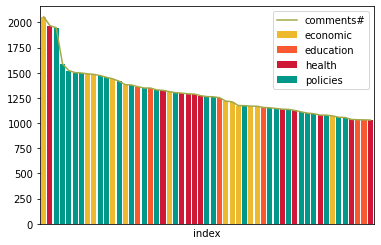

In [41]:
newsItems_sorted = all_newsItems.sort_values(['comments#'], ascending=[False])
newsItems_sorted = newsItems_sorted[newsItems_sorted["comments#"] > 1000]
newsItems_sorted = newsItems_sorted.reset_index()
newsItems_sorted = newsItems_sorted.drop(['index'], axis=1)
newsItems_sorted["economic"] = newsItems_sorted.apply(lambda x: get_topic(x, "economic", "comments#"), axis=1)
newsItems_sorted["education"] = newsItems_sorted.apply(lambda x : get_topic(x, "education", "comments#"), axis=1)
newsItems_sorted["health"] = newsItems_sorted.apply(lambda x : get_topic(x, "health", "comments#"), axis=1)
newsItems_sorted["policies"] = newsItems_sorted.apply(lambda x : get_topic(x, "policies", "comments#"), axis=1)

plot_df(newsItems_sorted, 'comments#')

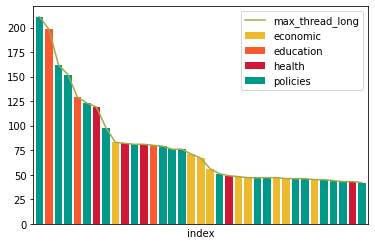

In [42]:
newsDataset = db[newspaperCollection].find({}, {"_id": 0})
thread_newsItems = pandas.DataFrame(list(newsDataset))

thread_newsItems["max_thread_long"] = all_newsItems['comments'].apply(lambda x: max_long_thread(x))
thread_newsItems_sorted = thread_newsItems.sort_values(['max_thread_long'], ascending=[False])

n = 40
newsItems_nLong = thread_newsItems_sorted[thread_newsItems_sorted["max_thread_long"] > n]
#newsItems_nLong
    
newsItems_nLong = newsItems_nLong.reset_index()
newsItems_nLong = newsItems_nLong.drop(['index'], axis=1)
newsItems_nLong["economic"] = newsItems_nLong.apply(lambda x: get_topic(x, "economic", "max_thread_long"), axis=1)
newsItems_nLong["education"] = newsItems_nLong.apply(lambda x : get_topic(x, "education", "max_thread_long"), axis=1)
newsItems_nLong["health"] = newsItems_nLong.apply(lambda x : get_topic(x, "health", "max_thread_long"), axis=1)
newsItems_nLong["policies"] = newsItems_nLong.apply(lambda x : get_topic(x, "policies", "max_thread_long"), axis=1)

plot_df(newsItems_nLong, "max_thread_long")

In [43]:
thread_newsItems["max_thread_long"] = all_newsItems['comments'].apply(lambda x: max_long_thread(x))
thread_newsItems_sorted = thread_newsItems.sort_values(['max_thread_long'], ascending=[False])
thread_newsItems_sorted['url'].head(10)

79      https://www.cbc.ca/news/politics/refugees-face...
474     https://www.cbc.ca/news/canada/calgary/require...
134     https://www.cbc.ca/news/politics/canadian-bank...
1596    https://www.cbc.ca/news/world/trump-mexico-wal...
1127    https://www.cbc.ca/news/politics/komagata-maru...
796     https://www.cbc.ca/news/politics/canada-immigr...
1323    https://www.cbc.ca/news/politics/health-care-b...
1506    https://www.cbc.ca/news/politics/liberal-trude...
489     https://www.cbc.ca/news/business/recession-can...
948     https://www.cbc.ca/news/politics/mcallum-philp...
Name: url, dtype: object